# Imports

In [1]:
%%time
from pyiron_contrib.tinybase.project import FilesystemProject, InMemoryProject, SingleHdfProject

/home/poul/pyiron/contrib/pyiron_contrib/__init__.py:9: UserWarning: pyiron module not found, importing Project from pyiron_base
  warnings.warn("pyiron module not found, importing Project from pyiron_base")


CPU times: user 1.48 s, sys: 980 ms, total: 2.46 s
Wall time: 1.47 s


In [2]:
from ase.calculators.morse import MorsePotential

In [3]:
import logging
logging.getLogger().setLevel(20)

# Create Project and a new Job


In [4]:
!rm -rf tinyjob

In [5]:
pr = FilesystemProject.open_location('tinyjob')

## MD Job

In [6]:
j = pr.create.job.AseMD('md')

In [7]:
j.input.structure = pr.create.structure.bulk('Fe', a=1.2, cubic=True).repeat(2).to_ase()
j.input.calculator = MorsePotential()

In [8]:
j.input.steps = 100
j.input.timestep = 3.0
j.input.temperature = 600.0
j.input.output_steps = 20

In [9]:
j.run()

In [10]:
j.status

'finished'

In [11]:
j.output.animate_structures()

NGLWidget(max_frame=21)

## Min Job

In [12]:
j = pr.create.job.AseMinimize('min')

In [13]:
j.input.structure = pr.create.structure.atoms(
    symbols=['Fe', 'Fe'], 
    positions=[[0,0,0], [0,0, .75]], 
    cell=[10,10,10]
).to_ase() # since our Atoms cannot be pickled, but parallel execution needs that we still convert back here
j.input.structure.rattle(1e-3)
j.input.calculator = MorsePotential()

In [14]:
j.input.lbfgs(damping=.25)
j.input.ionic_force_tolerance = 1e-3
j.input.max_steps = 100
j.input.output_steps = 10

In [15]:
j.run(
    submitter=pr.create.executor.process(4)
)
j.wait()
#FIXME: small race condition, other cells below can fail if executed too quickly.
import time
time.sleep(1)

       Step     Time          Energy         fmax
LBFGS:    0 18:00:52       11.288146      189.5231
LBFGS:    1 18:00:52        1.168671       43.6957
LBFGS:    2 18:00:52        0.860403       38.6924
LBFGS:    3 18:00:52        0.362400       30.3554
LBFGS:    4 18:00:52        0.004806       24.0865
LBFGS:    5 18:00:52       -0.267437       19.0615
LBFGS:    6 18:00:52       -0.471646       15.0628
LBFGS:    7 18:00:52       -0.623506       11.8810
LBFGS:    8 18:00:52       -0.735237        9.3518
LBFGS:    9 18:00:52       -0.816458        7.3435
LBFGS:   10 18:00:52       -0.874705        5.7512
LBFGS:   11 18:00:52       -0.915849        4.4909
LBFGS:   12 18:00:52       -0.944435        3.4955
LBFGS:   13 18:00:53       -0.963943        2.7113
LBFGS:   14 18:00:53       -0.977006        2.0956
LBFGS:   15 18:00:53       -0.985585        1.6137
LBFGS:   16 18:00:53       -0.991109        1.2382
LBFGS:   17 18:00:53       -0.994598        0.9468
LBFGS:   18 18:00:53       -0.99

In [16]:
j.status

'finished'

In [17]:
j.project.database.job_table()

id username name  jobtype_id  project_id  status_id location    status  \
0   1   pyiron   md           1           1          1  tinyjob  finished   
1   2   pyiron  min           2           1          2  tinyjob  finished   

              type  
0        AseMDTask  
1  AseMinimizeTask

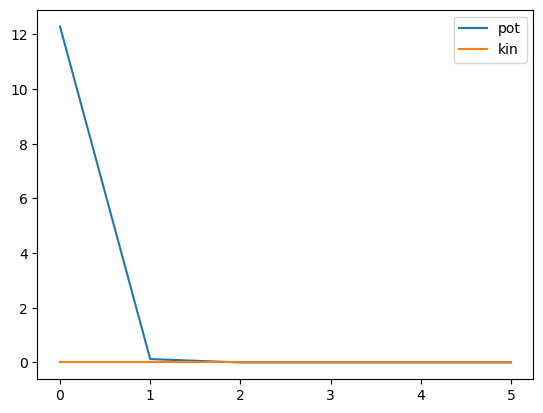

In [18]:
j.output.plot_energies()

In [19]:
j.output.animate_structures()

NGLWidget(max_frame=5)

### Loading from job id or name works

In [20]:
j.output.pot_energies

array([11.28814568, -0.87470498, -0.99887647, -0.99999594, -0.99999999,
       -1.        ])

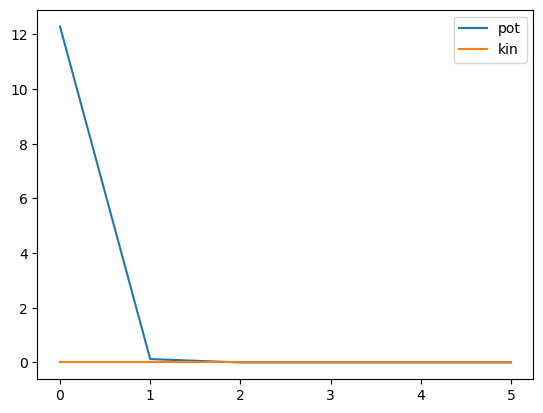

In [21]:
j.project.load(j.id).output.plot_energies()

In [22]:
j.project.load(j.name).output.animate_structures()

NGLWidget(max_frame=5)

## Murnaghan

In [23]:
murn = pr.create.job.Murnaghan('murn')

In [24]:
murn.input.task = pr.create.task.AseStatic()
murn.input.task.input.calculator = MorsePotential()

In [25]:
murn.input.structure = pr.create.structure.bulk("Fe", a=1.2).to_ase() # since our Atoms cannot be pickled, but parallel execution needs that we still convert back here

In [26]:
murn.input.set_strain_range(.5, 1000)

In [27]:
%%time
murn.run(submitter='process')
murn.wait()

CPU times: user 2.53 s, sys: 1.1 s, total: 3.64 s
Wall time: 35.1 s


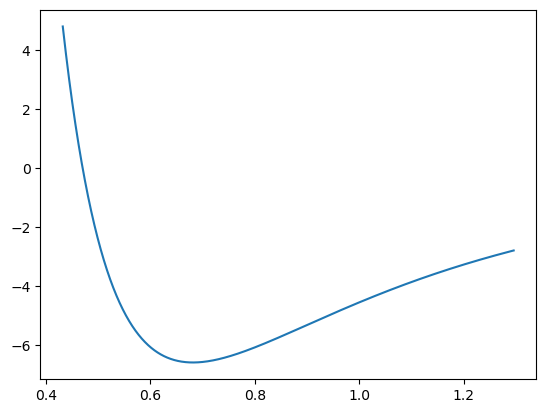

In [28]:
murn.output.plot()

# Alternative Project Implementations

Because the new ProjectInterface completely controls both the storage class and the database a job sees, we can easily swap them without changing anything in `TinyJob` at all.  As a demonstration we can make here a project that persists only for the duration of the process life time and one that keeps every job in a single file.  

## Pyiron in a single HDF file

In [29]:
!rm -rf tinyjob_single/

In [30]:
pr = SingleHdfProject.open_location('tinyjob_single')

### MD Job

In [31]:
for T in [300, 600, 900]:
    j = pr.create.job.AseMD(f'md_{T}')

    j.input.structure = pr.create.structure.bulk('Fe', a=1.2, cubic=True).repeat(2).to_ase()
    j.input.calculator = MorsePotential()

    j.input.steps = 100
    j.input.timestep = 3.0
    j.input.temperature = float(T)
    j.input.output_steps = 20

    j.run()

In [32]:
j.storage.list_all()

{'groups': ['output', 'task'], 'nodes': ['MODULE', 'NAME', 'VERSION']}

In [33]:
j.storage[".."].list_all()

{'groups': ['md_300', 'md_600', 'md_900'], 'nodes': []}

In [34]:
!ls -lha {pr.path}

total 1.9M
drwxr-xr-x 5 poul poul 4.0K Jan 26 18:02 .
drwxr-xr-x 7 poul poul 4.0K Jan 26 18:02 ..
drwxr-xr-x 3 poul poul 4.0K Jan 26 18:01 md_300
drwxr-xr-x 3 poul poul 4.0K Jan 26 18:01 md_600
drwxr-xr-x 3 poul poul 4.0K Jan 26 18:02 md_900
-rw-r--r-- 1 poul poul 1.8M Jan 26 18:02 project.h5
-rw-r--r-- 1 poul poul  20K Jan 26 18:02 pyiron.db


## Pyiron purely in memory

In [35]:
pr = InMemoryProject('/')

In [36]:
pr.job_table()

Empty DataFrame
Columns: []
Index: []

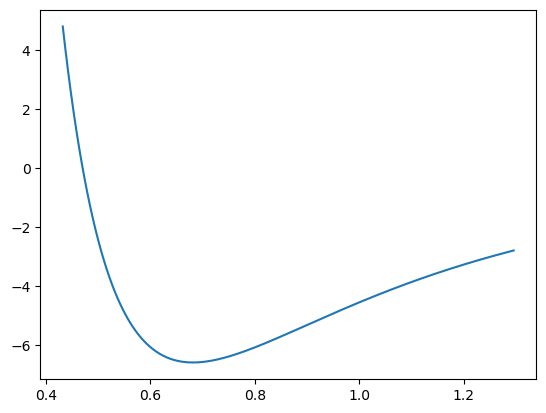

In [37]:
murn = pr.create.job.Murnaghan("murn")
murn.input.task = pr.create.task.AseStatic()
murn.input.task.input.calculator = MorsePotential()
murn.input.structure = pr.create.structure.bulk("Fe", a=1.2).to_ase() # since our Atoms cannot be pickled, but parallel execution needs that we still convert back here
murn.input.set_strain_range(.5, 500)
murn.run(submitter='process')
murn.wait()
murn.output.plot()

In [38]:
pr.job_table()

id username  name  jobtype_id  project_id  status_id location    status  \
0   1   pyiron  murn           1           1          1        /  finished   

            type  
0  MurnaghanTask

In [39]:
j = pr.create.job.AseMD('md')
j.input.structure = pr.create.structure.bulk('Fe', a=1.2, cubic=True).repeat(2).to_ase() # since our Atoms cannot be pickled, but parallel execution needs that we still convert back here
j.input.calculator = MorsePotential()
j.input.steps = 100
j.input.timestep = 3.0
j.input.temperature = 600.0
j.input.output_steps = 20
j.run(submitter='background')
j.wait()

In [40]:
pr.job_table()

id username  name  jobtype_id  project_id  status_id location    status  \
0   1   pyiron  murn           1           1          1        /  finished   
1   2   pyiron    md           2           1          2        /  finished   

            type  
0  MurnaghanTask  
1      AseMDTask

Subprojects work.

In [41]:
sub = pr.open_location("/foo")
j = sub.create.job.AseMD('md')
j.input.structure = pr.create.structure.bulk('Fe', a=1.2, cubic=True).repeat(2).to_ase() # since our Atoms cannot be pickled, but parallel execution needs that we still convert back here
j.input.calculator = MorsePotential()
j.input.steps = 100
j.input.timestep = 3.0
j.input.temperature = 600.0
j.input.output_steps = 20
j.run()

In [42]:
pr.job_table()

id username  name  jobtype_id  project_id  status_id location    status  \
0   1   pyiron  murn           1           1          1        /  finished   
1   2   pyiron    md           2           1          2        /  finished   
2   3   pyiron    md           2           2          3     /foo  finished   

            type  
0  MurnaghanTask  
1      AseMDTask  
2      AseMDTask